# Figure S13. Effect of conduction delay on goodness-of-fit and E-I ratio

In [1]:
import set_env  # not included in the repo, defines $PROJECT_DIR, $PNC_PROJECT_DIR, $IMAGEN_PROJECT_DIR & $INPUT_DIR

In [2]:
import sys
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats
import pickle
from tqdm import tqdm

OUTPUT_DIR = {
    "pnc": os.path.join(os.environ["PNC_PROJECT_DIR"], "output"),
    "imagen": os.path.join(os.environ["IMAGEN_PROJECT_DIR"], "output"),
    "micamics": os.path.join(os.environ["PROJECT_DIR"], "output", "micamics")
}
INPUT_DIR = os.environ["INPUT_DIR"]
CODE_DIR = os.path.join(os.getcwd(), "..", "scripts")
sys.path.append(CODE_DIR)
from utils import transform, stats

import warnings
warnings.filterwarnings('ignore')

plt.rcParams.update({'font.size': 16, "font.family": "Asana Math", "figure.dpi": 300})
thcolor = '#44546A'
add_text = True # add statistics as text to some figures

/data/project/ei_development/env/lib/python3.10/site-packages/nilearn/input_data/__init__.py:23: FutureWarning: The import path 'nilearn.input_data' is deprecated in version 0.9. Importing from 'nilearn.input_data' will be possible at least until release 0.13.0. Please import from 'nilearn.maskers' instead.
  warnings.warn(message, FutureWarning)


Load data of the main run and select the 200 subsample subjects:

In [3]:
elig_subs = pd.read_csv(
    os.path.join(INPUT_DIR, "pnc_subs.csv"), index_col=0
).sort_index()
parcels = transform.load_ordered_parcel_labels('schaefer-100')

if os.path.exists('pnc_optima.csv') & os.path.exists('pnc_vars.pkz'):
    subjects_optima = pd.read_csv('pnc_optima.csv', index_col=0)
    with open('pnc_vars.pkz', 'rb') as f:
        regional_vars = pickle.load(f)
else:
    raise FileNotFoundError("Run Figure 2 first")

# limit the optima to subsample
subsample = np.loadtxt(os.path.join(INPUT_DIR, 'pnc_subsample_200.txt'), dtype=str)
subjects_optima = subjects_optima.loc[subjects_optima['sub'].isin(subsample)]

# select optimal runs and add demographics
best_runs = subjects_optima.groupby("sub")["gof"].idxmax().values
data = subjects_optima.loc[best_runs].set_index("sub")
data[["age", "sex"]] = elig_subs.loc[data.index, ["age", "sex"]]
data["Age (y)"] = data["age"] / 12

Split data into two age groups for comparing ICCs between them:

In [4]:
data_by_age = {
    'younger': data.loc[data['age']<data['age'].median()],
    'older': data.loc[data['age']>=data['age'].median()]
}

Load data:

In [5]:
all_v_IE = {}
all_v_fits = {}
vlist = ['v-orig_dt-0.1', 'v-orig_dt-1.0', 'v-1', 'v-2', 'v-3', 'v-4', 'v-5', 'v-6']

for v in vlist:
    all_v_IE[v] = pd.DataFrame(index=data.index, columns=parcels)
    all_v_fits[v] = {}
    for sub, row in tqdm(data.iterrows()):
        cmaes_log_path = os.path.join(
            OUTPUT_DIR['pnc'], 'sim', sub, 
            'ctx_parc-schaefer-100_mean001_thresh-1',
            '6maps_schaefer-100_zscore', 'cmaes_multimaps_gpu',
            f'ctx_parc-schaefer-100_hemi-LR_highpass-013_lowpass'\
            f'-none_exc-inter_G_0.5-4_wee_0.05-0.75_wei_0.05-0.75_wie_0_'\
            f'het-wee-wei_SeedMW-{row["SeedMW"]}_SeedSim-410_n-81x210.txt')
        base_dir = cmaes_log_path.replace('.txt', '_cubnm')
        if not os.path.exists(base_dir):
            print(sub, "not found")
            continue
        try:
            sim_data = np.load(os.path.join(base_dir, v, 'it1.npz'), allow_pickle=True)
        except FileNotFoundError:
            print(sub, "not found")
            continue
        all_v_IE[v].loc[sub, :] = sim_data['sim_states'].flatten()[0]['I_E'].squeeze()
        all_v_fits[v][sub] = pd.read_csv(os.path.join(base_dir, v, 'score.csv'), index_col=0).T.iloc[:, 0]
    all_v_fits[v] = pd.DataFrame(all_v_fits[v]).T
    # make the cubnm gof measures comparable to the main results (without -/+ signs)
    all_v_fits[v][['-fc_diff', '-fcd_ks']] = -all_v_fits[v][['-fc_diff', '-fcd_ks']]
    all_v_fits[v].columns = [s.replace('-','').replace('+','') for s in all_v_fits[v].columns]

200it [00:03, 58.06it/s]
200it [00:01, 102.58it/s]
200it [00:01, 105.02it/s]
200it [00:01, 106.19it/s]
200it [00:01, 101.34it/s]
200it [00:01, 111.96it/s]
200it [00:01, 111.14it/s]
200it [00:01, 109.26it/s]


## A. Goodness-of-fit comparison

In [6]:
gof_labels = {
    'gof': 'Goodness-of-fit',
    'fc_corr': 'FC correlation',
    'fc_diff': 'FC difference',
    'fcd_ks': 'FCD KS distance',
}

gof v-1 -0.13263895967884506 0.8946129406281045 -0.0004511791643930146 0.0481052998975329
gof v-2 2.50874382321947 0.012914317324970979 0.004222278381636315 0.02380156672896939
gof v-3 3.044288491706942 0.0026475505682130164 0.0031000121060003796 0.014400997723341096
gof v-4 3.0480859167589514 0.002615811698366441 0.002116023254533816 0.009817665468040783
gof v-5 3.2612760693338423 0.001304926980974031 0.0016725747145615066 0.0072529212342895884
gof v-6 3.574623512326994 0.00044015255700913513 0.0014730415352887719 0.0058277334940600705
fc_corr v-1 1.824519119564511 0.06957320096836317 0.0005458509556960981 0.004230976898526511
fc_corr v-2 3.2025386904369793 0.0015861889238227463 0.0004642907317230205 0.0020502679691193097
fc_corr v-3 2.058353807278569 0.040859158557631 0.00019689153343983732 0.0013527639219381776
fc_corr v-4 1.3038573654173589 0.19378846183155965 9.238308468803344e-05 0.0010020222668900506
fc_corr v-5 0.6502558126993997 0.5162769827071357 3.501740072299087e-05 0.00076

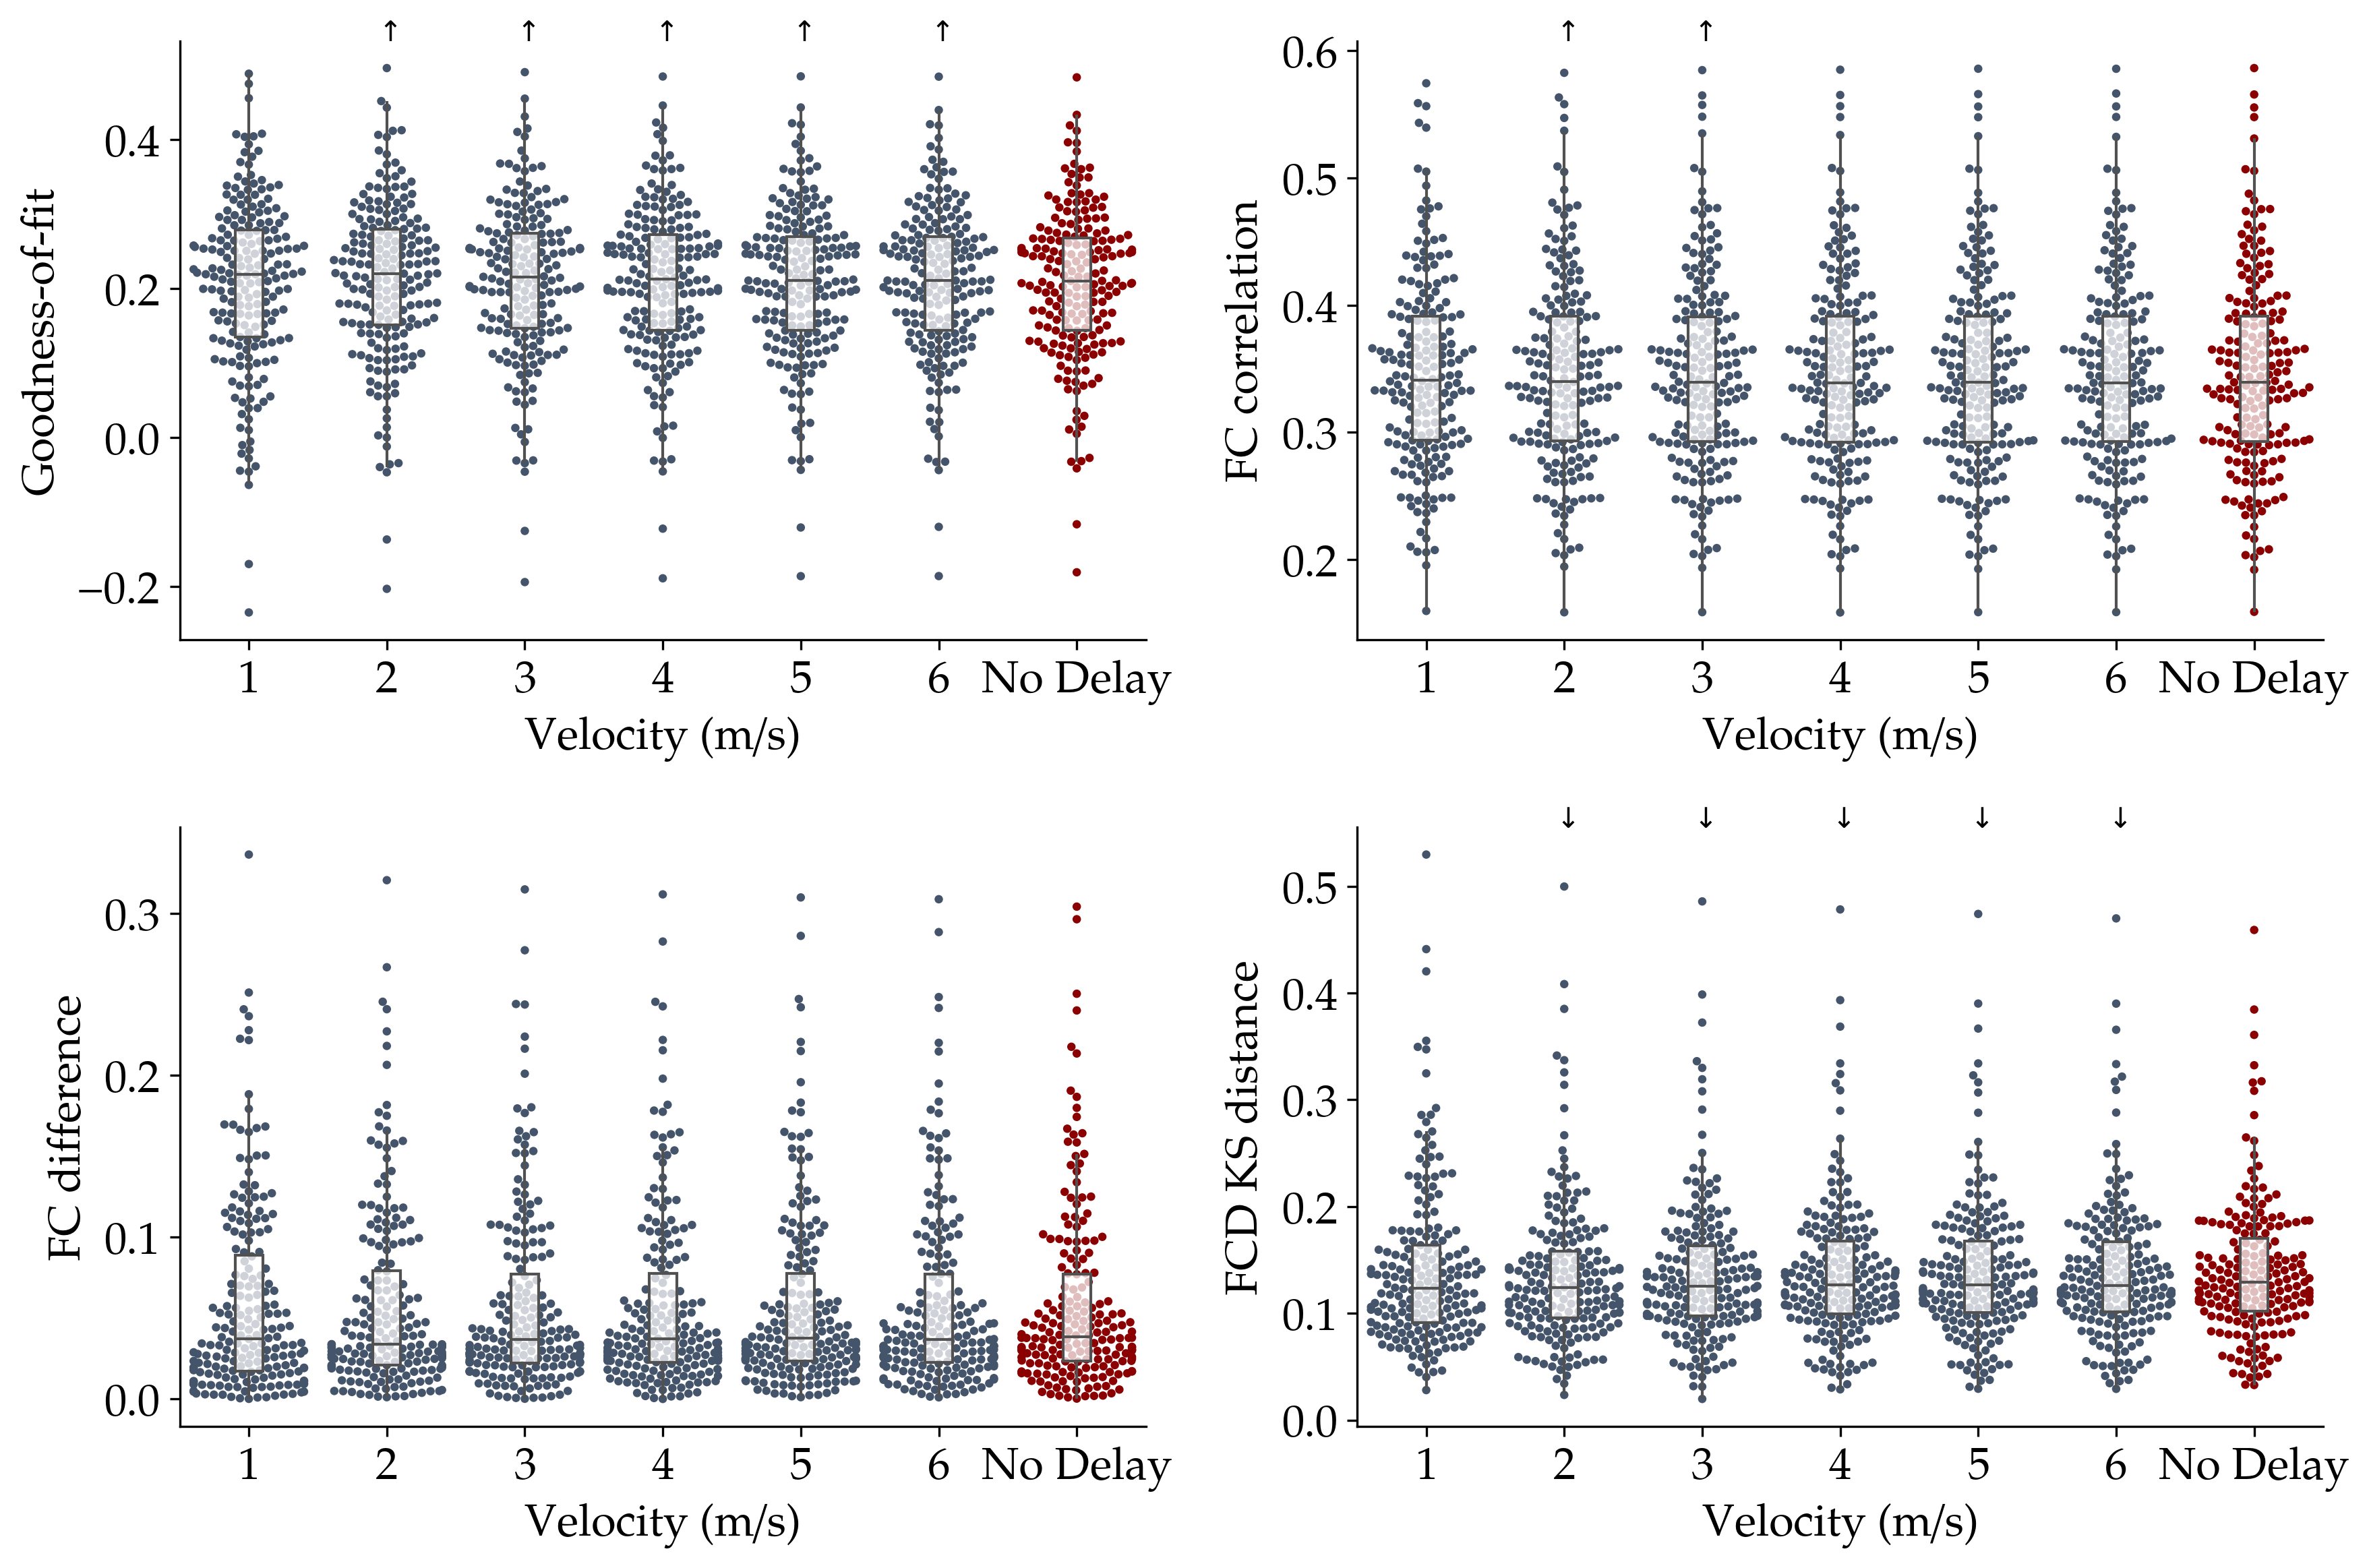

In [7]:
# exclude dt-0.1 and sort the velocities >0
vlist_ordered = vlist[1:2] + vlist[-1:1:-1]
vlist_ordered = vlist_ordered[::-1]
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.flatten()
for i, (col, label) in enumerate(gof_labels.items()):
    ax = axes[i]
    plot_data = {}
    for v in vlist_ordered:
        plot_data[v] = all_v_fits[v].loc[:, col]
    plot_data = pd.DataFrame(plot_data).unstack().reset_index()
    sns.swarmplot(
        data=plot_data,
        x='level_0', y=0,
        s=3, palette=[thcolor]*(len(vlist_ordered)-1)+['darkred'],
        ax=ax
    )
    sns.boxplot(
        data=plot_data,
        x='level_0', y=0,
        showfliers=False,
        showcaps=False, width=0.2,
        boxprops={"facecolor": (1, 1, 1, 0.75)},
        ax=ax)
    plt.setp(ax.collections, zorder=0, label="") # puts swarm in the back
    ax.set_ylabel(label)
    ax.set_xticklabels(list(range(1, 7)) + ['No Delay'])
    ax.set_xlabel('Velocity (m/s)')
    sns.despine()
    # print statistics and add significant increase/decrease indicator
    for j, v in enumerate(vlist_ordered[:-1]):
        t, p = scipy.stats.ttest_rel(all_v_fits[v].loc[:, col], all_v_fits['v-orig_dt-1.0'].loc[:, col])
        if p < 0.05:
            text_x = j-0.10
            text_y = ax.get_ylim()[1]
            if t < 0:
                text = r'$\downarrow$'
            else:
                text = r'$\uparrow$'
            # text = '*'
            ax.text(text_x, text_y, text, fontsize=10, multialignment='center')
        diff = (all_v_fits[v].loc[:, col] - all_v_fits['v-orig_dt-1.0'].loc[:, col])
        print(col, v, t, p, diff.mean(), diff.std())
fig.tight_layout(pad=1.0)

## B. Node-level intraclass correlation of E-I ratio

In [8]:
icc_v = pd.DataFrame(index=parcels, columns=vlist_ordered[:-1], dtype=float)
for v in tqdm(vlist_ordered[:-1]):
    for i, parc in enumerate(parcels):
        icc_df = pd.DataFrame(index=data.index, dtype=float)
        for sub in data.index:
            icc_df.loc[sub, 'orig'] = all_v_IE['v-orig_dt-1.0'].loc[sub, parc]
            icc_df.loc[sub, v] = all_v_IE[v].loc[sub, parc]
        icc_v.loc[parc, v] = stats.madicc(icc_df.loc[:, 'orig'], icc_df.loc[:, v])

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:25<00:00,  4.20s/it]


In [9]:
icc_v.describe().round(3)

,v-1,v-2,v-3,v-4,v-5,v-6
count,100.000,100.000,100.000,100.000,100.000,100.000
mean,0.977,0.989,0.993,0.995,0.997,0.997
std,0.017,0.008,0.005,0.004,0.003,0.002
min,0.908,0.963,0.966,0.979,0.980,0.987
25%,0.970,0.988,0.991,0.993,0.996,0.997
50%,0.983,0.991,0.995,0.996,0.997,0.998
75%,0.988,0.995,0.997,0.998,0.999,0.999
max,0.998,0.999,1.000,1.000,1.000,1.000


Comparison of ICC between younger and older age groups:

In [10]:
icc_v_by_age = {
    'younger': pd.DataFrame(index=parcels, columns=vlist_ordered[:-1], dtype=float),
    'older': pd.DataFrame(index=parcels, columns=vlist_ordered[:-1], dtype=float)
}
for v in tqdm(vlist_ordered[:-1]):
    for i, parc in enumerate(parcels):
        icc_df = pd.DataFrame(index=data.index, dtype=float)
        for sub in data.index:
            icc_df.loc[sub, 'orig'] = all_v_IE['v-orig_dt-1.0'].loc[sub, parc]
            icc_df.loc[sub, v] = all_v_IE[v].loc[sub, parc]
        for age in data_by_age.keys():
            subs = data_by_age[age].index
            icc_v_by_age[age].loc[parc, v] = stats.madicc(icc_df.loc[subs, 'orig'], icc_df.loc[subs, v])
    print(v, scipy.stats.ttest_rel(icc_v_by_age['younger'][v], icc_v_by_age['older'][v]))

 17%|███████████████████████████▊                                                                                                                                           | 1/6 [00:04<00:22,  4.51s/it]

v-1 TtestResult(statistic=1.2725077584194517, pvalue=0.20617331480844203, df=99)


 33%|███████████████████████████████████████████████████████▋                                                                                                               | 2/6 [00:09<00:18,  4.51s/it]

v-2 TtestResult(statistic=1.447981785729201, pvalue=0.15078173978563392, df=99)


 50%|███████████████████████████████████████████████████████████████████████████████████▌                                                                                   | 3/6 [00:13<00:14,  4.69s/it]

v-3 TtestResult(statistic=0.40211467879639334, pvalue=0.6884664783635475, df=99)


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                       | 4/6 [00:18<00:09,  4.60s/it]

v-4 TtestResult(statistic=0.01829840758047946, pvalue=0.9854376255661634, df=99)


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 5/6 [00:22<00:04,  4.56s/it]

v-5 TtestResult(statistic=-0.8835628360723348, pvalue=0.3790728792316437, df=99)


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:27<00:00,  4.57s/it]

v-6 TtestResult(statistic=0.10467091542689123, pvalue=0.9168487112751641, df=99)


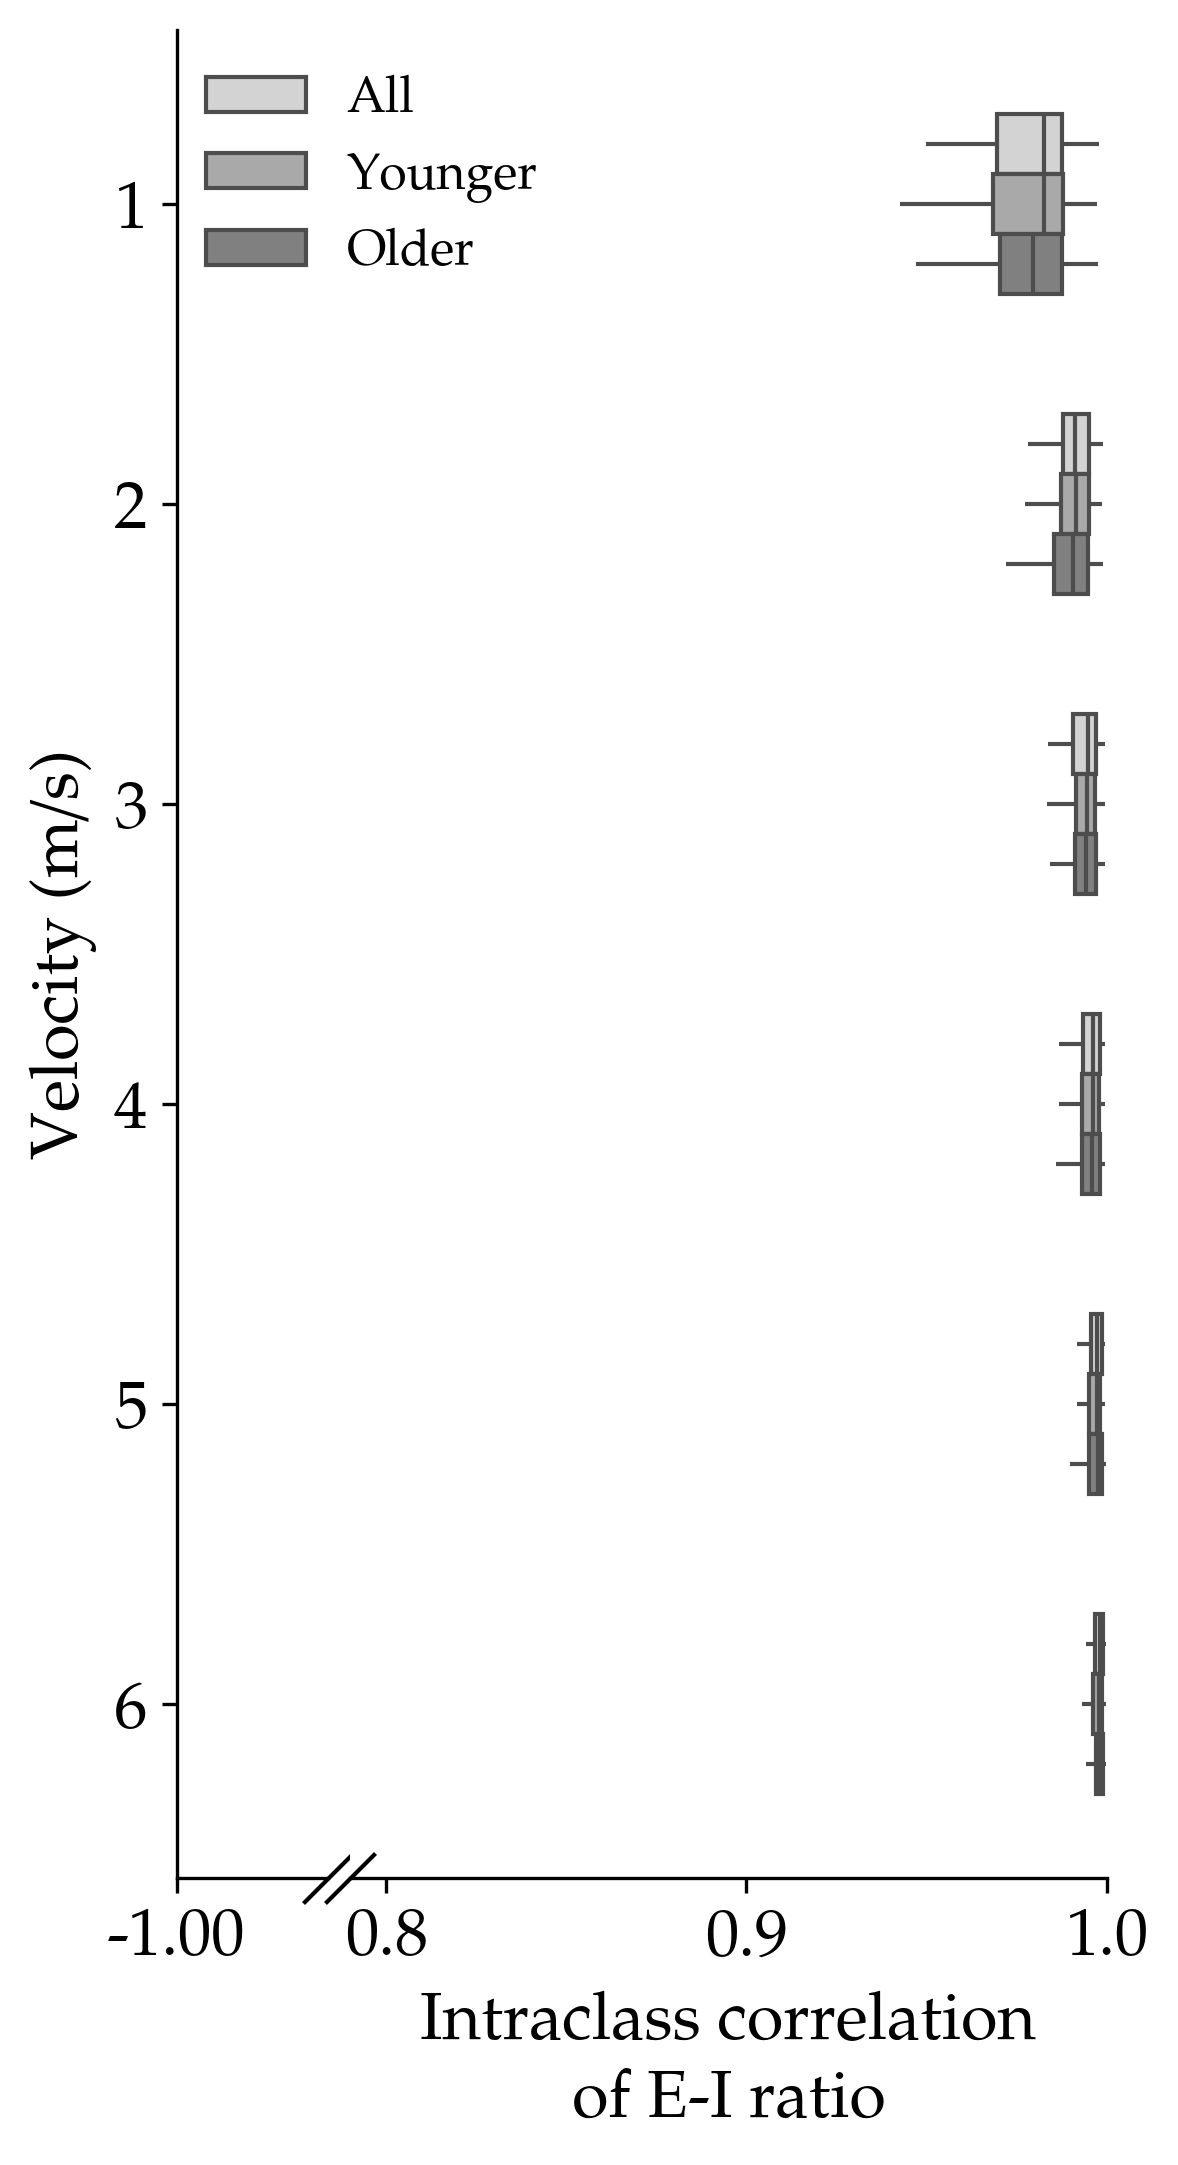

In [11]:
fig, (ax2, ax1) = plt.subplots(1, 2, figsize=(4, 8), sharex=False, gridspec_kw={'width_ratios': [1, 5], 'wspace': 0.05})

plot_data = []

long_df = icc_v.unstack().reset_index()
long_df['group'] = 'All'
plot_data.append(long_df)
for age in icc_v_by_age.keys():
    long_df = icc_v_by_age[age].unstack().reset_index()
    long_df['group'] = age.title()
    plot_data.append(long_df)

plot_data = pd.concat(plot_data, axis=0)

# dummy boxplot for the broken axis starting from -1
sns.boxplot(
    data=plot_data,
    y='level_0',
    hue='group',
    x=0,
    showfliers=False,
    showcaps=False, width=0.6,
    palette=['lightgrey', 'darkgrey', 'grey'],
    ax=ax2,
    legend=False
)
ax2.set_xlim(-1, -0.92)
ax2.set_xticks([-1.0], labels=['-1.00'])
ax2.set_yticklabels(list(range(1, 7)))
ax2.set_ylabel('Velocity (m/s)')
ax2.set_xlabel('')
sns.despine(ax=ax2)

sns.boxplot(
    data=plot_data,
    y='level_0',
    hue='group',
    x=0,
    showfliers=False,
    showcaps=False, width=0.6,
    palette=['lightgrey', 'darkgrey', 'grey'],
    ax=ax1,
    legend=True
)

ax1.legend(loc='upper left', fontsize=12, frameon=False, bbox_to_anchor=(-0.25, 1.0))
ax1.set_xlim(0.79, 1)
ax1.set_xlabel('Intraclass correlation\n'
               r'of E-I ratio')
ax1.set_yticks([])
ax1.set_ylabel('')
sns.despine(ax=ax1, left=True)

d = 1  # proportion of vertical to horizontal extent of the slanted line
kwargs = dict(marker=[(-1, -d), (1, d)], markersize=12,
              linestyle="none", color='k', mec='k', mew=1, clip_on=False)
ax2.plot([1], [0], transform=ax2.transAxes, **kwargs)
ax1.plot([0], [0], transform=ax1.transAxes, **kwargs)


# since none of the p-values are significant, will not implement the significance indicator